# We will run CellPose on train and test sets and evaluate results. Note the labelled data comes from human-in-the-loop approach (done via the GUI).

Note code is adapted from [CellPose](https://github.com/MouseLand/cellpose) page for our particular use case. Furthermore, the relevant papers for this code are [Cellpose: a generalist algorithm for cellular segmentation](https://t.co/kBMXmPp3Yn?amp=1), [Cellpose 2.0: how to train your own model](https://www.nature.com/articles/s41592-022-01663-4) and [Cellpose 3.0: one-click image restoration for improved segmentation](https://www.biorxiv.org/content/10.1101/2024.02.10.579780v1).

## We first install Cellpose.

In [ ]:
!pip install "opencv-python-headless<4.3"
!pip install cellpose

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 MB 15.3 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.9.0.80
    Uninstalling opencv-python-headless-4.9.0.80:
      Successfully uninstalled opencv-python-headless-4.9.0.80
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 1.3.1 requires opencv-python-headless>=4.1.1, but you have opencv-python-headless 3.4.18.65 which is incompatible.
qudida 0.0.4 requires opencv-python-headless>=4.0.1, but you have opencv-python-headless 3.4.18.65 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.6/39.6 MB 17.1 MB/s eta 0:00:00


Check CUDA version and that GPU is working in cellpose and import other libraries.

In [ ]:
!nvcc --version
!nvidia-smi

import os, shutil
import numpy as np
import matplotlib.pyplot as plt
from cellpose import core, utils, io, models, metrics
from cellpose.io import logger_setup
from glob import glob

use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
Wed Mar  6 16:13:57 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8              10W /  7

## Mount Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Define the path to train and test images and masks, as well as the path to where we will save our models.

In [ ]:
#@markdown ###Path to images and masks:
train_dir = "/content/gdrive/MyDrive/glialCellsImages/train" #@param {type:"string"}
test_dir = "/content/gdrive/MyDrive/glialCellsImages/test" #@param {type:"string"}

## Training cyto Model.

In [ ]:
# model name and path
#@markdown ###Name of the pretrained model to start from and new model name:
from cellpose import models
initial_model = "cyto" #@param ['cyto','nuclei','tissuenet','livecell','cyto2','CP','CPx','TN1','TN2','TN3','LC1','LC2','LC3','LC4','scratch']
model_name = "cytoModelTrained" #@param {type:"string"}

# other parameters for training.
#@markdown ###Training Parameters:
#@markdown Number of epochs:
n_epochs =  100#@param {type:"number"}

Channel_to_use_for_training = "Green" #@param ["Grayscale", "Blue", "Green", "Red"]

Second_training_channel= "Blue" #@param ["None", "Blue", "Green", "Red"]

learning_rate = 0.1 #@param {type:"number"}
weight_decay = 0.0001 #@param {type:"number"}

#here we check that no model with the same name already exist, if so delete
model_path = train_dir + 'models/'
if os.path.exists(model_path+'/'+model_name):
  print("!! WARNING: "+model_name+" already exists and will be deleted in the following cell !!")

# Here we match the channel to number
if Channel_to_use_for_training == "Grayscale":
  chan = 0
elif Channel_to_use_for_training == "Blue":
  chan = 3
elif Channel_to_use_for_training == "Green":
  chan = 2
elif Channel_to_use_for_training == "Red":
  chan = 1

if Second_training_channel == "Blue":
  chan2 = 3
elif Second_training_channel == "Green":
  chan2 = 2
elif Second_training_channel == "Red":
  chan2 = 1
elif Second_training_channel == "None":
  chan2 = 0

if initial_model=='scratch':
  initial_model = 'None'

In [ ]:
# logger to see training across epochs
from cellpose.io import logger_setup
from cellpose import train

logger_setup()

# set channels
channels = [chan, chan2]

# get files
output = io.load_train_test_data(train_dir, test_dir, mask_filter='_seg.npy')
train_data, train_labels, _, test_data, test_labels, _ = output

# Initialize lists to store IoUs and ROI counts
ious = []
roi_counts = []

# Iterate over each training image
for i in range(len(train_data)):
    # DEFINE CELLPOSE MODEL (without size model)
    model = models.CellposeModel(gpu=use_GPU, model_type=initial_model)

    # Train the model
    new_model_path = train.train_seg(model.net, train_data=train_data[:i+1],
                              train_labels=train_labels[:i+1],
                              test_data=test_data,
                              test_labels=test_labels,
                              channels=channels,
                              save_path=train_dir,
                              n_epochs=n_epochs,
                              learning_rate=learning_rate,
                              weight_decay=weight_decay,
                              SGD=True,
                              nimg_per_epoch=8,
                              model_name=f"{model_name}_{i+1}")

    # diameter of labels in training images
    diam_labels = model.net.diam_labels.item()

    # Evaluate the model on the test dataset
    masks = model.eval(test_data, channels=channels, diameter=diam_labels)[0]

    # Compute IoU for each test image and average
    ap = metrics.average_precision(test_labels, masks)[0]
    mean_iou = ap[:, 0].mean()
    ious.append(mean_iou)

    seg_file_path = "/content/gdrive/MyDrive/glialCellsImages/train/train" + str(i+1) + "_seg.npy"
    seg_file = np.load(seg_file_path, allow_pickle=True).item()
    roi_count = len(np.unique(seg_file['masks']))-1 # minus 1 since we don't consider background ROI

    roi_counts.append(roi_count)

100%|██████████| 5/5 [00:00<00:00, 157.63it/s]


In [ ]:
ious

[0.7622619,
 0.79567593,
 0.8616152,
 0.8427318,
 0.847335,
 0.84585935,
 0.8336004,
 0.8476933,
 0.8377553,
 0.8601147,
 0.842868,
 0.84748113,
 0.85338545,
 0.838006,
 0.85165817]

In [ ]:
roi_counts

[59, 135, 88, 113, 142, 149, 111, 71, 79, 81, 183, 94, 52, 60, 93]

## Cyto Model: Final iou given 15 images.

In [ ]:
print(f'>>> average precision at iou threshold 0.5 for final cyto model = {ious[-1]:.3f}')

>>> average precision at iou threshold 0.5 for final cyto model = 0.852


## Cyto Model: Plot of average precision at iou = 0.5 against number of training ROIs.

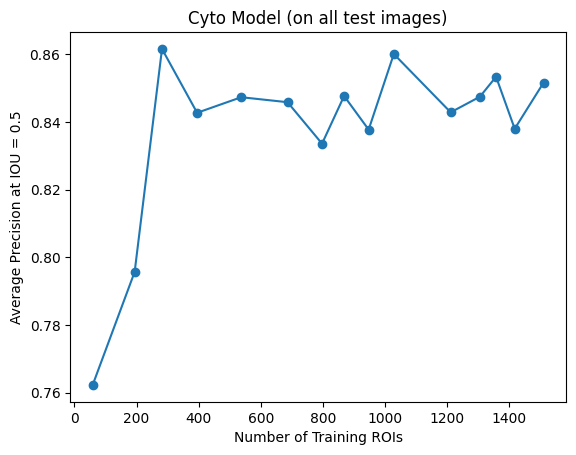

In [ ]:
# Calculate cumulative sum of ROI counts
cumulative_roi_counts = [sum(roi_counts[:i+1]) for i in range(len(roi_counts))]

# Plotting
plt.plot(cumulative_roi_counts, ious, marker='o')
plt.xlabel('Number of Training ROIs')
plt.ylabel('Average Precision at IOU = 0.5')
plt.title('Cyto Model (on all test images)')
plt.show()

## Optional code to check if the average precision at roi = 0.5 for individual pretrained models were correct. Note you can change the pretrained_model path to check your own model on the test set.

In [ ]:
# declare model
model = models.CellposeModel(gpu=True,
                             pretrained_model='/content/gdrive/MyDrive/glialCellsImages/train/models/cytoModelTrained_15')

# use model diameter
diameter = model.diam_labels

# get files (during training, test_data is transformed so we will load it again)
output = io.load_train_test_data(test_dir, mask_filter='_seg.npy')
test_data, test_labels = output[:2]

# run model on test images
masks = model.eval(test_data,
                   channels=[chan, chan2],
                   diameter=diameter)[0]

# check performance using ground truth labels
ap = metrics.average_precision(test_labels, masks)[0]
print('')
print(f'>>> average precision at iou threshold 0.5 = {ap[:,0].mean():.3f}')


>>> average precision at iou threshold 0.5 = 0.852


## Training cyto2 Model.

In [ ]:
# model name and path
#@markdown ###Name of the pretrained model to start from and new model name:
from cellpose import models
initial_model = "cyto2" #@param ['cyto','nuclei','tissuenet','livecell','cyto2','CP','CPx','TN1','TN2','TN3','LC1','LC2','LC3','LC4','scratch']
model_name = "cyto2ModelTrained" #@param {type:"string"}

# other parameters for training.
#@markdown ###Training Parameters:
#@markdown Number of epochs:
n_epochs =  100#@param {type:"number"}

Channel_to_use_for_training = "Green" #@param ["Grayscale", "Blue", "Green", "Red"]

Second_training_channel= "Blue" #@param ["None", "Blue", "Green", "Red"]

learning_rate = 0.1 #@param {type:"number"}
weight_decay = 0.0001 #@param {type:"number"}

#here we check that no model with the same name already exist, if so delete
model_path = train_dir + 'models/'
if os.path.exists(model_path+'/'+model_name):
  print("!! WARNING: "+model_name+" already exists and will be deleted in the following cell !!")

# Here we match the channel to number
if Channel_to_use_for_training == "Grayscale":
  chan = 0
elif Channel_to_use_for_training == "Blue":
  chan = 3
elif Channel_to_use_for_training == "Green":
  chan = 2
elif Channel_to_use_for_training == "Red":
  chan = 1

if Second_training_channel == "Blue":
  chan2 = 3
elif Second_training_channel == "Green":
  chan2 = 2
elif Second_training_channel == "Red":
  chan2 = 1
elif Second_training_channel == "None":
  chan2 = 0

if initial_model=='scratch':
  initial_model = 'None'

In [ ]:
# logger to see training across epochs
from cellpose.io import logger_setup
from cellpose import train

logger_setup();

# set channels
channels = [chan, chan2]

# get files
output = io.load_train_test_data(train_dir, test_dir, mask_filter='_seg.npy')
train_data, train_labels, _, test_data, test_labels, _ = output

# Initialize lists to store IoUs and ROI counts
ious = []
roi_counts = []

# Iterate over each training image
for i in range(len(train_data)):
    # DEFINE CELLPOSE MODEL (without size model)
    model = models.CellposeModel(gpu=use_GPU, model_type=initial_model)

    # Train the model
    new_model_path = train.train_seg(model.net, train_data=train_data[:i+1],
                              train_labels=train_labels[:i+1],
                              test_data=test_data,
                              test_labels=test_labels,
                              channels=channels,
                              save_path=train_dir,
                              n_epochs=n_epochs,
                              learning_rate=learning_rate,
                              weight_decay=weight_decay,
                              SGD=True,
                              nimg_per_epoch=8,
                              model_name=f"{model_name}_{i+1}")

    # diameter of labels in training images
    diam_labels = model.net.diam_labels.item()

    # Evaluate the model on the test dataset
    masks = model.eval(test_data, channels=channels, diameter=diam_labels)[0]

    # Compute IoU for each test image and average
    ap = metrics.average_precision(test_labels, masks)[0]
    mean_iou = ap[:, 0].mean()
    ious.append(mean_iou)

    seg_file_path = "/content/gdrive/MyDrive/glialCellsImages/train/train" + str(i+1) + "_seg.npy"
    seg_file = np.load(seg_file_path, allow_pickle=True).item()
    roi_count = len(np.unique(seg_file['masks']))-1 # minus 1 since we don't consider background ROI

    roi_counts.append(roi_count)

100%|██████████| 25.3M/25.3M [00:00<00:00, 29.0MB/s]
100%|██████████| 5/5 [00:00<00:00, 179.58it/s]


In [ ]:
ious

[0.7979084,
 0.7651717,
 0.8383876,
 0.821946,
 0.8273457,
 0.8340392,
 0.83079135,
 0.83247864,
 0.8128768,
 0.83299446,
 0.8379798,
 0.83425367,
 0.83072835,
 0.82291067,
 0.8339793]

In [ ]:
roi_counts

[59, 135, 88, 113, 142, 149, 111, 71, 79, 81, 183, 94, 52, 60, 93]

## Cyto2 Model: Final iou given 15 images.

In [ ]:
print(f'>>> average precision at iou threshold 0.5 for final cyto2 model = {ious[-1]:.3f}')

>>> average precision at iou threshold 0.5 for final cyto2 model = 0.834


## Cyto2 Model: Plot of average precision at iou = 0.5 against number of training ROIs.

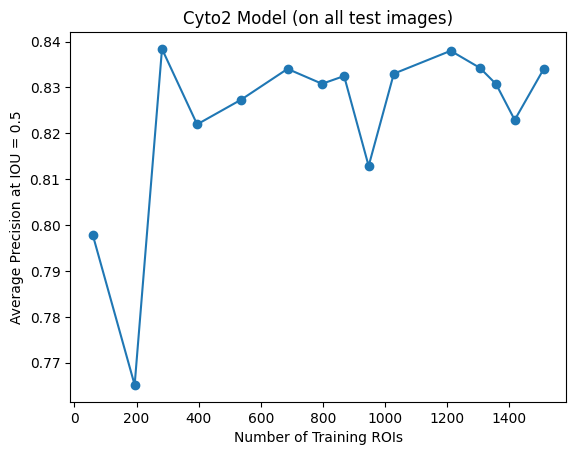

In [ ]:
# Calculate cumulative sum of ROI counts
cumulative_roi_counts = [sum(roi_counts[:i+1]) for i in range(len(roi_counts))]

# Plotting
plt.plot(cumulative_roi_counts, ious, marker='o')
plt.xlabel('Number of Training ROIs')
plt.ylabel('Average Precision at IOU = 0.5')
plt.title('Cyto2 Model (on all test images)')
plt.show()

## Training cyto3 Model.

In [ ]:
# model name and path
#@markdown ###Name of the pretrained model to start from and new model name:
from cellpose import models
initial_model = "cyto3" #@param ['cyto','nuclei','tissuenet','livecell','cyto2', 'CP','CPx','TN1','TN2','TN3','LC1','LC2','LC3','LC4','scratch', 'cyto3']
model_name = "cyto3ModelTrained" #@param {type:"string"}

# other parameters for training.
#@markdown ###Training Parameters:
#@markdown Number of epochs:
n_epochs =  100#@param {type:"number"}

Channel_to_use_for_training = "Green" #@param ["Grayscale", "Blue", "Green", "Red"]

Second_training_channel= "Blue" #@param ["None", "Blue", "Green", "Red"]

learning_rate = 0.1 #@param {type:"number"}
weight_decay = 0.0001 #@param {type:"number"}

#here we check that no model with the same name already exist, if so delete
model_path = train_dir + 'models/'
if os.path.exists(model_path+'/'+model_name):
  print("!! WARNING: "+model_name+" already exists and will be deleted in the following cell !!")

# Here we match the channel to number
if Channel_to_use_for_training == "Grayscale":
  chan = 0
elif Channel_to_use_for_training == "Blue":
  chan = 3
elif Channel_to_use_for_training == "Green":
  chan = 2
elif Channel_to_use_for_training == "Red":
  chan = 1

if Second_training_channel == "Blue":
  chan2 = 3
elif Second_training_channel == "Green":
  chan2 = 2
elif Second_training_channel == "Red":
  chan2 = 1
elif Second_training_channel == "None":
  chan2 = 0

if initial_model=='scratch':
  initial_model = 'None'

In [ ]:
# logger to see training across epochs
from cellpose.io import logger_setup
from cellpose import train

logger_setup();

# set channels
channels = [chan, chan2]

# get files
output = io.load_train_test_data(train_dir, test_dir, mask_filter='_seg.npy')
train_data, train_labels, _, test_data, test_labels, _ = output

# Initialize lists to store IoUs and ROI counts
ious = []
roi_counts = []

# Iterate over each training image
for i in range(len(train_data)):
    # DEFINE CELLPOSE MODEL (without size model)
    model = models.CellposeModel(gpu=use_GPU, model_type=initial_model)

    # Train the model
    new_model_path = train.train_seg(model.net, train_data=train_data[:i+1],
                              train_labels=train_labels[:i+1],
                              test_data=test_data,
                              test_labels=test_labels,
                              channels=channels,
                              save_path=train_dir,
                              n_epochs=n_epochs,
                              learning_rate=learning_rate,
                              weight_decay=weight_decay,
                              SGD=True,
                              nimg_per_epoch=8,
                              model_name=f"{model_name}_{i+1}")

    # diameter of labels in training images
    diam_labels = model.net.diam_labels.item()

    # Evaluate the model on the test dataset
    masks = model.eval(test_data, channels=channels, diameter=diam_labels)[0]

    # Compute IoU for each test image and average
    ap = metrics.average_precision(test_labels, masks)[0]
    mean_iou = ap[:, 0].mean()
    ious.append(mean_iou)

    seg_file_path = "/content/gdrive/MyDrive/glialCellsImages/train/train" + str(i+1) + "_seg.npy"
    seg_file = np.load(seg_file_path, allow_pickle=True).item()
    roi_count = len(np.unique(seg_file['masks']))-1 # minus 1 since we don't consider background ROI

    roi_counts.append(roi_count)

100%|██████████| 25.3M/25.3M [00:00<00:00, 29.2MB/s]
100%|██████████| 5/5 [00:00<00:00, 190.54it/s]


In [ ]:
ious

[0.62982744,
 0.7033333,
 0.7238893,
 0.71389204,
 0.7104541,
 0.70972717,
 0.7035421,
 0.7147258,
 0.6955356,
 0.70469725,
 0.6936332,
 0.7070769,
 0.714928,
 0.72567654,
 0.73857725]

In [ ]:
roi_counts

[59, 135, 88, 113, 142, 149, 111, 71, 79, 81, 183, 94, 52, 60, 93]

## Cyto3 Model: Final iou given 15 images.

In [ ]:
print(f'>>> average precision at iou threshold 0.5 for final cyto3 model = {ious[-1]:.3f}')

>>> average precision at iou threshold 0.5 for final cyto3 model = 0.739


## Cyto3 Model: Plot of average precision at iou = 0.5 against number of training ROIs.

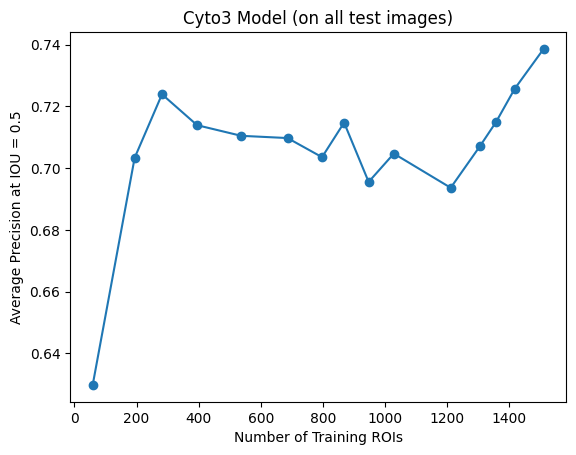

In [ ]:
# Calculate cumulative sum of ROI counts
cumulative_roi_counts = [sum(roi_counts[:i+1]) for i in range(len(roi_counts))]

# Plotting
plt.plot(cumulative_roi_counts, ious, marker='o')
plt.xlabel('Number of Training ROIs')
plt.ylabel('Average Precision at IOU = 0.5')
plt.title('Cyto3 Model (on all test images)')
plt.show()

From these results, we can observe that when trained on 15 images (with their segmentations obtained using a human-in-the-loop approach) and tested on 5 manually annotated images, we see that the average precision at iou threshold 0.5 is higher for the final cytoModelTrained. Thus, we will use cytoModelTrained to segment all the images we have access to.

# Run our best model to segment our images.

In [ ]:
# model name and path

#@markdown ###Full path to custom model:

model_path = "/content/gdrive/MyDrive/glialCellsImages/train/models/cytoModelTrained_15" #@param {type:"string"}

#@markdown ###Path to images:

dir = "/content/gdrive/MyDrive/images" #@param {type:"string"}

#@markdown ###Channel Parameters:

Channel_to_use_for_segmentation = "Green" #@param ["Grayscale", "Blue", "Green", "Red"]

# @markdown If you have a secondary channel that can be used, for instance nuclei, choose it here:

Second_segmentation_channel= "Blue" #@param ["None", "Blue", "Green", "Red"]


# Here we match the channel to number
if Channel_to_use_for_segmentation == "Grayscale":
  chan = 0
elif Channel_to_use_for_segmentation == "Blue":
  chan = 3
elif Channel_to_use_for_segmentation == "Green":
  chan = 2
elif Channel_to_use_for_segmentation == "Red":
  chan = 1


if Second_segmentation_channel == "Blue":
  chan2 = 3
elif Second_segmentation_channel == "Green":
  chan2 = 2
elif Second_segmentation_channel == "Red":
  chan2 = 1
elif Second_segmentation_channel == "None":
  chan2 = 0

#@markdown ### Segmentation parameters:

#@markdown diameter of cells (default uses diameter from training set):
diameter =  0#@param {type:"number"}
#@markdown threshold on flow error to accept a mask (set higher to get more cells, e.g. in range from (0.1, 3.0), OR set to 0.0 to turn off so no cells discarded):
flow_threshold = 0.4 #@param {type:"slider", min:0.0, max:3.0, step:0.1}
#@markdown threshold on cellprob output to seed cell masks (set lower to include more pixels or higher to include fewer, e.g. in range from (-6, 6)):
cellprob_threshold=0 #@param {type:"slider", min:-6, max:6, step:1}

Copy images to a new folder (denoted by dir+initial_model).

In [ ]:
files = io.get_image_files(dir, '_masks')
dir = dir + "/" + model_path.split("/")[-1] + "/"
os.makedirs(dir, exist_ok=True)
for f in files:
  dst = dir + os.path.split(f)[1]
  print(f'{f} > {dst}')
  shutil.copyfile(f, dst)

/content/gdrive/MyDrive/images/image1.png > /content/gdrive/MyDrive/images/cytoModelTrained_15/image1.png
/content/gdrive/MyDrive/images/image2.png > /content/gdrive/MyDrive/images/cytoModelTrained_15/image2.png
/content/gdrive/MyDrive/images/image3.png > /content/gdrive/MyDrive/images/cytoModelTrained_15/image3.png
/content/gdrive/MyDrive/images/image4.png > /content/gdrive/MyDrive/images/cytoModelTrained_15/image4.png
/content/gdrive/MyDrive/images/image5.png > /content/gdrive/MyDrive/images/cytoModelTrained_15/image5.png
/content/gdrive/MyDrive/images/image6.png > /content/gdrive/MyDrive/images/cytoModelTrained_15/image6.png
/content/gdrive/MyDrive/images/image7.png > /content/gdrive/MyDrive/images/cytoModelTrained_15/image7.png
/content/gdrive/MyDrive/images/image8.png > /content/gdrive/MyDrive/images/cytoModelTrained_15/image8.png
/content/gdrive/MyDrive/images/image9.png > /content/gdrive/MyDrive/images/cytoModelTrained_15/image9.png
/content/gdrive/MyDrive/images/image10.png > /

In [ ]:
# gets image files in dir (ignoring image files ending in _masks)
files = io.get_image_files(dir, '_masks')
print(files)
images = [io.imread(f) for f in files]

['/content/gdrive/MyDrive/images/cytoModelTrained_15/image1.png', '/content/gdrive/MyDrive/images/cytoModelTrained_15/image2.png', '/content/gdrive/MyDrive/images/cytoModelTrained_15/image3.png', '/content/gdrive/MyDrive/images/cytoModelTrained_15/image4.png', '/content/gdrive/MyDrive/images/cytoModelTrained_15/image5.png', '/content/gdrive/MyDrive/images/cytoModelTrained_15/image6.png', '/content/gdrive/MyDrive/images/cytoModelTrained_15/image7.png', '/content/gdrive/MyDrive/images/cytoModelTrained_15/image8.png', '/content/gdrive/MyDrive/images/cytoModelTrained_15/image9.png', '/content/gdrive/MyDrive/images/cytoModelTrained_15/image10.png', '/content/gdrive/MyDrive/images/cytoModelTrained_15/image11.png', '/content/gdrive/MyDrive/images/cytoModelTrained_15/image12.png', '/content/gdrive/MyDrive/images/cytoModelTrained_15/image13.png', '/content/gdrive/MyDrive/images/cytoModelTrained_15/image14.png', '/content/gdrive/MyDrive/images/cytoModelTrained_15/image15.png', '/content/gdrive/M

In [ ]:
# declare model
model = models.CellposeModel(gpu=use_GPU,
                             pretrained_model=model_path)

# use model diameter if user diameter is 0
diameter = model.diam_labels if diameter==0 else diameter

# run model on test images
masks, flows, styles = model.eval(images,
                                  channels=[chan, chan2],
                                  diameter=diameter,
                                  flow_threshold=flow_threshold,
                                  cellprob_threshold=cellprob_threshold
                                  )

# save output to *_seg.npy
Save the results.

In [ ]:
from cellpose import io

io.masks_flows_to_seg(images,
                      masks,
                      flows,
                      diameter*np.ones(len(masks)),
                      files,
                      [chan, chan2])